## **Module 3 Final Project**

    Title: Northwind Database
    Submitted By: RU KEÏN
    Date: December 5, 2019
    Instructor: James Irving PhD
    https://vimeo.com/rukein/northwind-datascience-project-presentation
    http://www.hakkeray.com/datascience/2019/12/07/thinking-outside-the-lego-box.html

---
## Introduction

The goal of this project is to recommend business strategies for increasing sales and saving costs for the Northwind company. This project is based on a fictitious business database created by Microsoft for the use of practicing SQL, hypothesis testing and other data analysis related projects. 

Below are 4 hypotheses (each including a null hypothesis and alternative hypothesis) which I will test for statistical significance to determine if there are any relationships which would be useful from a strategic business perspective. Following this I will summarize the results, make final recommendations, and propose ideas for future analytical work.

--------------------------
## Objectives

**H1: Discount and Order Quantity**

Does discount amount have a statistically significant effect on order quantity? If so, at what level(s) of discount?

**H2: Countries and Order Quantity: Discount vs Full Price**

Do order quantities of individual countries differ when discounted vs full price?

**H3: Region and Order Revenue**

Does region have a statistically significant effect on average revenue per order?

**H4: Time of Year (Month) and Order Revenue**

Does time of year have a statistically significant effect on average revenue per order?

---
## Process Outline

Outline of process I will follow in order to answer questions above:

- Question
    1. Hypotheses
    2. Exploratory Data Analysis (EDA)
        - Select dataset
        - Group data
        - Explore data
    3. Assumption Tests:
        - Sample size
        - Normality and Variance
    4. Statistical Tests:
        - Statistical test
        - Effect size (if necessary)
        - Post-hoc tests (if necessary)
    5. Summarize Results

---

## Statistical Analysis Pipeline 

For #3 and #4 above (Assumption and Statistical Tests):

1. Check if sample sizes allow us to ignore assumptions by visualizing sample size comparisons for two groups (normality check).
    * Bar Plot: SEM (Standard Error of the Mean)

2. If above test fails, check for normality and homogeneity of variance:
    * Test Assumption Normality:
        - D'Agostino-Pearson: scipy.stats.normaltest
        - Shapiro-Wilik Test: scipy.stats.shapiro
    
    * Test for Homogeneity of Variance:
        - Levene's Test: scipy.stats.levene)
Parametric tests (means)	Nonparametric tests (medians)
1-sample t test	1-sample Sign, 1-sample Wilcoxon
2-sample t test	Mann-Whitney tes
One-Way ANOVA	Kruskal-Wallis, Mood’s median tes
Factorial DOE with one factor and one blocking variable	Friedman test
3. Choose appropriate test based on above
    * T Test (1-sample)
         - `stats.ttest_1samp()`
    * T Test (2-sample)
        - stats.ttest_ind()
    * Welch's T-Test (2-sample)
        - stats.ttest_ind(equal_var=False)
    * Mann Whitney U
        - stats.mannwhitneyu()
    * ANOVA
        - stats.f_oneway()

4. Calculate effect size for significant results.
    * Effect size: 
        - cohen's d

    -Interpretation:
    - Small effect = 0.2 ( cannot be seen by naked eye)
    - Medium effect = 0.5
    - Large Effect = 0.8 (can be seen by naked eye)


5. If significant, follow up with post-hoc tests (if have more than 2 groups)
    * Tukey's
        - statsmodels.stats.multicomp.pairwise_tukeyhsd

## Data Prep

In [1]:
# install requisite libraries and packages
!pip install -U fsds_100719 --user
from fsds_100719.imports import *

fsds_1007219  v0.4.45 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [10]:
from fsds_100719.ds import ihelp, reload
import fsds_100719 as fs

In [15]:
#fs.ft.hakkeray.hot_stats()

In [16]:
# connect to database / import data
import sqlite3 
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [17]:
# function for converting tables into dataframes on the fly
def get_table(cur, table):
    cur.execute(f"SELECT * from {table};")
    df = pd.DataFrame(cur.fetchall())
    df.columns = [desc[0] for desc in cur.description]
    return df

In [18]:
# create dataframe of table names for referencing purposes
cur.execute("""SELECT name from sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


In [19]:
from IPython.display import HTML
HTML('<img src="https://github.com/hakkeray/dsc-mod-3-project-online-ds-ft-100719/blob/master/Northwind_ERD_updated.png?raw=true">')


# H1: Discount--Quantity

* Does discount amount have a statistically significant effect on the quantity of a product in an order? 
* If so, at what level(s) of discount?

## Hypotheses
- $H_0$: Discount amount has no relationship with the quantity of a product in an order.
- $H_A$: Discount amount has a statistically significant effect on the quantity in an order.

- $\alpha$=0.05

## EDA
Select the proper dataset for analysis, perform EDA, and generate data groups for testing.

### Select dataset

In [20]:
df_orderDetail = get_table(cur, 'OrderDetail')
df_orderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### Group

In [21]:
# check value counts for each level of discount
df_orderDetail['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [22]:
# insert boolean column showing whether or not an order was discounted
df_orderDetail['discounted'] = np.where(df_orderDetail['Discount'] == 0.0, 0, 1)

# compare number of discount vs fullprice orders
df_orderDetail['discounted'].value_counts()

0    1317
1     838
Name: discounted, dtype: int64

In [23]:
# split orders into two groups: discount and fullprice
fullprice = df_orderDetail.groupby('discounted').get_group(0)['Quantity']
discount = df_orderDetail.groupby('discounted').get_group(1)['Quantity']

0    12
1    10
2     5
3     9
4    40
Name: Quantity, dtype: int64

6     35
7     15
8      6
9     15
11    40
Name: Quantity, dtype: int64

### Explore

In [24]:
fullprice.mean()

21.715261958997722

In [25]:
discount.mean()

27.10978520286396

At first glance it looks like the average quantities are indeed higher for discounted orders compared to those that are full price.

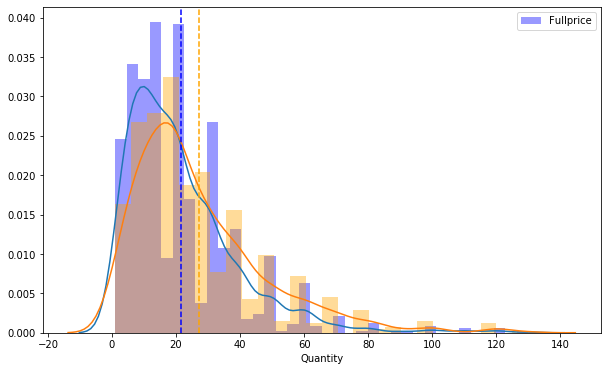

In [80]:
## Examine KDEs
fig, ax = plt.subplots(figsize=(10,6))

group1 = {'name':'fullprice',
         'data':fullprice,
         'n':fullprice.value_counts()}

plot1 = {'hist_kws':dict(color='blue',lw=2, ls='-')}



group2 = {'name':'discount',
         'data':discount,
         'n':discount.value_counts()}

plot2 = {'hist_kws':dict(color='orange',lw=2, ls='-')}



label1= f"{group1['name']} n={group1['n']}"


sns.distplot(group1['data'], label=label1,
             ax=ax, hist_kws=plot1['hist_kws'],)

ax.legend(['Fullprice'])

label2= f"{group2['name']} n={group2['n']}"
sns.distplot(group2['data'], label=label2,
             ax=ax,hist_kws=plot2['hist_kws'])


ax.axvline(group1['data'].mean(),color=plot1['hist_kws']['color'], ls='--')
ax.axvline(group2['data'].mean(),color=plot2['hist_kws']['color'], ls='--')

## Assumption Tests
**Select the appropriate t-test based on tests for the assumptions of normality and homogeneity of variance.**

### Sample Size
Check if sample sizes allow us to ignore assumptions; if not, test assumption normality.

<BarContainer object of 1 artists>

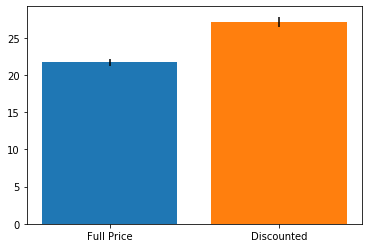

In [81]:
# visualize sample size comparisons for two groups (normality check)
import scipy.stats as stat
plt.bar(x='Full Price', height=fullprice.mean(), yerr=stat.sem(fullprice))
plt.bar(x='Discounted', height=discount.mean(), yerr=stat.sem(discount))

### Normality Test
Check assumptions of normality and homogeneity of variance

In [28]:
# Test for normality - D'Agostino-Pearson's normality test: scipy.stats.normaltest
stat.normaltest(fullprice), stat.normaltest(discount)

(NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119),
 NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57))

Failed normality test (p-values < 0.05). Run non-parametric test:

In [29]:
# Run non-parametric test (since normality test failed)
stat.mannwhitneyu(fullprice, discount)

MannwhitneyuResult(statistic=461541.0, pvalue=6.629381826999866e-11)

### Statistical Test
Perform chosen statistical test.

Text(0.5, 1.0, 'Discount Levels and Order Qty')

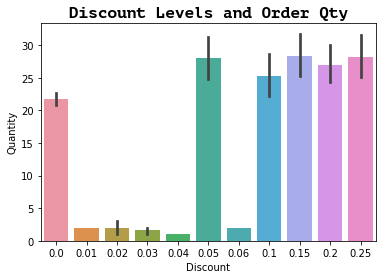

In [30]:
ax = sns.barplot(x='Discount', y='Quantity', data=df_orderDetail)
ax.set_title('Discount Levels and Order Qty', fontdict={'family': 'PT Mono', 'size':16})

In [31]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_orderDetail['Quantity'].values
labels = df_orderDetail['Discount'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

In [32]:
# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
1,0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
2,0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
3,0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
4,0.0,0.05,6.2955,0.0011,1.5381,11.053,True
5,0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
6,0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
7,0.0,0.15,6.6669,0.0014,1.551,11.7828,True
8,0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
9,0.0,0.25,6.525,0.0023,1.3647,11.6852,True


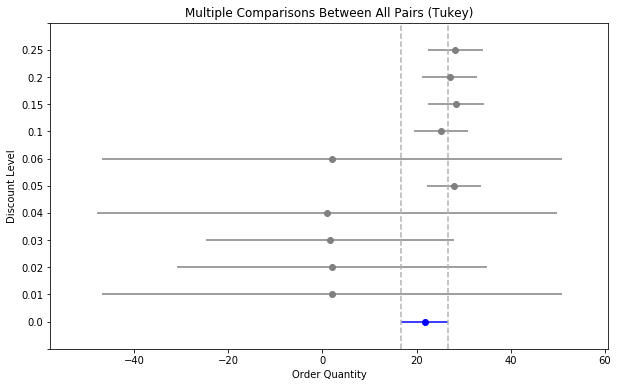

In [39]:
# Plot a universal confidence interval of each group mean comparing significant differences in group means. 
# Significant differences at the alpha=0.05 level can be identified by intervals that do not overlap 

oq_data = df_orderDetail['Quantity'].values
discount_labels = df_orderDetail['Discount'].values

from statsmodels.stats.multicomp import MultiComparison
oqd = MultiComparison(oq_data, discount_labels)
results = oqd.tukeyhsd()
results.plot_simultaneous(comparison_name=0.0, xlabel='Order Quantity', ylabel='Discount Level');

### Effect Size
Calculate effect size using Cohen's D as well as any post-hoc tests.

In [40]:
#### Cohen's d
def Cohen_d(group1, group2):
    # Compute Cohen's d.
    # group1: Series or NumPy array
    # group2: Series or NumPy array
    # returns a floating point number 
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [41]:
Cohen_d(discount, fullprice)

0.2862724481729282

### Post-hoc Tests

In [46]:
df_discount = df_orderDetail.loc[(df_orderDetail['Discount'] >= 0.05) & (df_orderDetail['Discount'] != 0.06) & (df_orderDetail['Discount'] != 0.1)]
df_discount.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.0
mean,10663.499239,39.462709,26.540898,27.911720,0.157534,1.0
std,234.887169,22.083659,29.951397,20.576407,0.075660,0.0
min,10250.000000,1.000000,2.000000,1.000000,0.050000,1.0
25%,10461.000000,21.000000,12.500000,14.000000,0.050000,1.0
50%,10663.000000,40.000000,18.400000,21.000000,0.150000,1.0
75%,10854.000000,59.000000,32.000000,40.000000,0.200000,1.0
max,11077.000000,77.000000,263.500000,120.000000,0.250000,1.0


In [52]:
df_discount.loc[df_discount['discounted'] == 1, 'OQD_Effective'] = True
df_discount.loc[df_discount['discounted'] == 0, 'OQD_Effective'] = False
df_discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD_Effective
6,10250/51,10250,51,42.4,35,0.15,1,True
7,10250/65,10250,65,16.8,15,0.15,1,True
8,10251/22,10251,22,16.8,6,0.05,1,True
9,10251/57,10251,57,15.6,15,0.05,1,True
11,10252/20,10252,20,64.8,40,0.05,1,True


<BarContainer object of 1 artists>

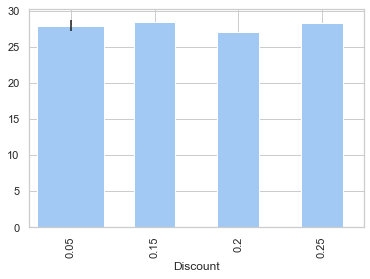

In [173]:
df_discount.groupby(['Discount'])['Quantity'].mean().plot.bar()
plt.bar(x='Discount', height=df_discount.Quantity.mean(), yerr=df_discount.Quantity.sem())

The mean quantity per order is similar for each of the discount levels that we identified as significant. The obvious conclusion to draw from this is that offering a discount higher than 5% does not increase the order quantities; higher discounts only produce higher loss in revenue.

In [36]:
# Determine amount of revenue lost by grouping orders by discount = 5% vs discount < or > 5% and != 0
# dataframe containing insignificant discount levels
d = df_orderDetail.loc[df_orderDetail['OQD'] == 0]
# dataframe containing significant discount levels
discount_df = df_orderDetail.loc[df_orderDetail['OQD'] == 1]

In [37]:
mean_qty_fp = fullprice_df.Quantity.mean()
mean_qty_dc = discount_df.Quantity.mean()
print(mean_qty_fp, mean_qty_dc)

22.01535380507343 27.911719939117198


In [38]:
diff = mean_qty_dc - mean_qty_fp
diff

5.896366134043767

In [39]:
from pandas_profiling import ProfileReport
#ProfileReport(df_oqd)

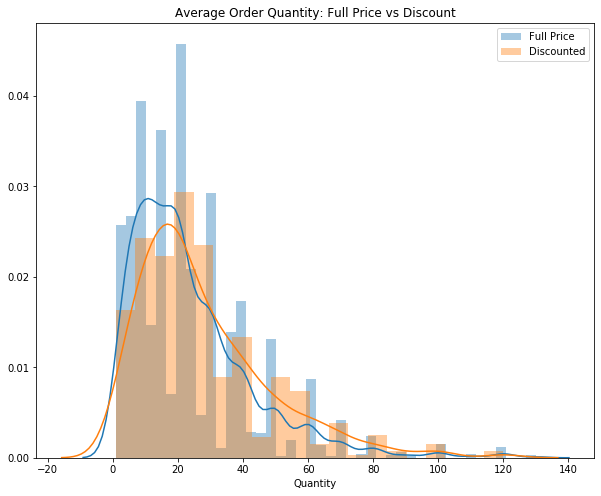

In [135]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(title="Average Order Quantity: Full Price vs Discount", xlabel="Avg Quantity Per Order")
sns.distplot(df_orderDetail.Quantity)
sns.distplot(df_oqd.Quantity)
ax.legend(['Full Price', 'Discounted'])

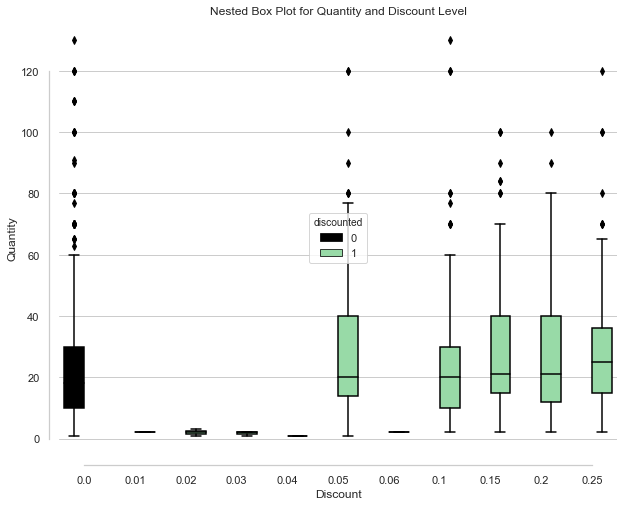

In [175]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(title="Nested Box Plot for Quantity and Discount Level")
# GROUPED BOXPLOTS
sns.set(style="whitegrid", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Discount", y="Quantity",
            hue="discounted", palette=["black", "g"],
            data=df_orderDetail)
sns.despine(offset=10, trim=True)

In [331]:
# Extract revenue lost per discounted order where discount had no effect on order quantity
cur.execute("""SELECT Discount, 
                SUM(UnitPrice * Quantity) as 'revLoss',
                COUNT(OrderId) as 'NumOrders'
                FROM orderDetail  
                GROUP BY Discount
                HAVING Discount != 0 AND Discount != 0.05
                ORDER BY revLoss DESC;""")
df = pd.DataFrame(cur.fetchall())
df. columns = [i[0] for i in cur.description]
print(len(df))
df.head()


9


,Discount,revLoss,NumOrders
0,0.25,131918.09,154
1,0.20,111476.38,161
2,0.15,102948.44,157
3,0.10,101665.71,173
4,0.03,124.65,3


## Analyze Results

Where alpha = 0.05, the null hypothesis is rejected. Discount amount has a statistically significant effect on the quantity in an order where the discount level is equal to 5%, 15%, 20% or 25%.

# H2: Country--Discount

**Do individual countries show a statistically significant preference for discount?**

**If so, which countries and to what extent?** 

## Hypotheses

- $H_0$: Countries purchase equal quantities of discounted vs non-discounted products.
- $H_A$: Countries purchase different quantities of discounted vs non-discounted products.

## EDA
Select the proper dataset for analysis, perform EDA, and generate data groups for testing.

### Select

In [86]:
df_order = get_table(cur, "'Order'")
display(df_order.head())
display(df_orderDetail.head())

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


In [87]:
# Rename 'Id' to 'OrderId' for joining tables with matching primary key name
df_order.rename({'Id':'OrderId'}, axis=1, inplace=True)
display(df_order.head())

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


### Explore

In [88]:
df_order.set_index('OrderId',inplace=True)
display(df_order.head())

,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
OrderId,,,,,,,,,,,,,
10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


### Group

In [89]:
df_countries = df_orderDetail.merge(df_order, on='OrderId', copy=True)
df_countries.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [90]:
countries = df_countries.groupby('ShipCountry').groups
countries.keys()

dict_keys(['Argentina', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Ireland', 'Italy', 'Mexico', 'Norway', 'Poland', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'UK', 'USA', 'Venezuela'])

In [91]:
df_countries.loc[df_countries['discounted'] == 1]['ShipCountry'].value_counts()

Germany        150
USA            142
Brazil          95
France          77
Austria         58
Venezuela       46
Sweden          39
Ireland         35
Canada          31
Italy           27
UK              26
Switzerland     24
Denmark         19
Portugal        18
Finland         15
Belgium         14
Spain           14
Mexico           8
Name: ShipCountry, dtype: int64

In [92]:
df_countries.loc[df_countries['discounted'] == 0]['ShipCountry'].value_counts()

USA            210
Germany        178
UK             109
Brazil         108
France         107
Venezuela       72
Austria         67
Mexico          64
Sweden          58
Canada          44
Belgium         42
Spain           40
Finland         39
Argentina       34
Switzerland     28
Denmark         27
Italy           26
Ireland         20
Poland          16
Norway          16
Portugal        12
Name: ShipCountry, dtype: int64

## Test

### Sample Size


Argentina PREFERS DISCOUNTS!
Austria


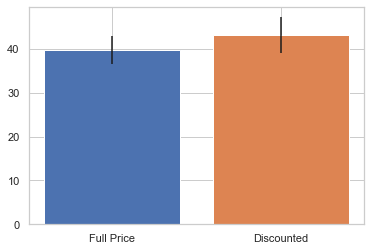

Belgium


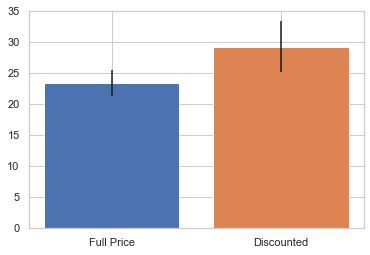

Brazil


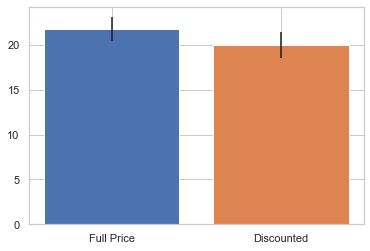

Canada


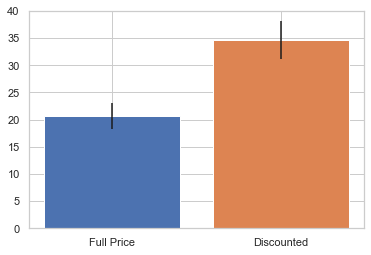


Canada PREFERS DISCOUNTS!
Denmark


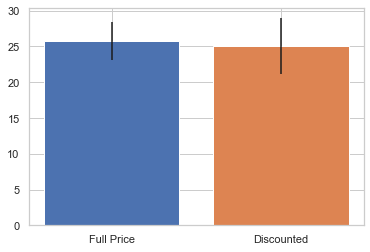

Finland


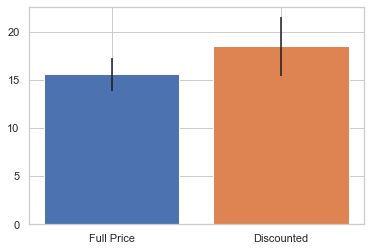

France


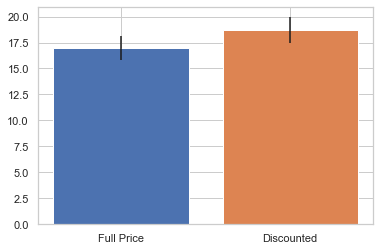

Germany


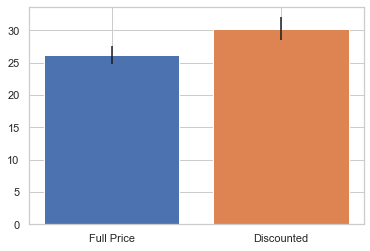

Ireland


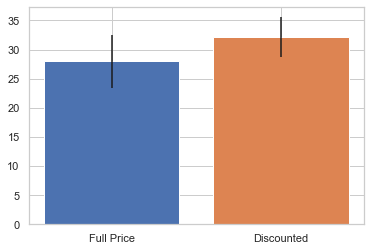

Italy


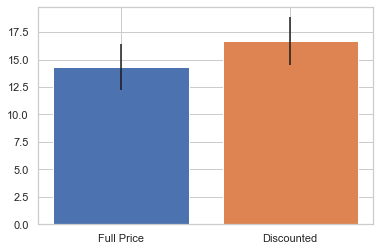

Mexico


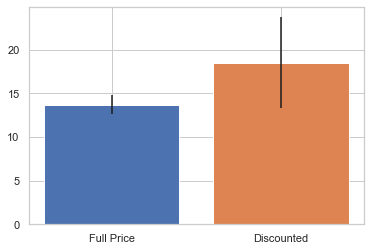


Norway PREFERS DISCOUNTS!
Portugal


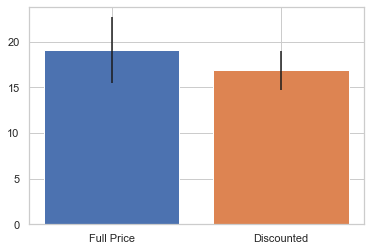

Spain


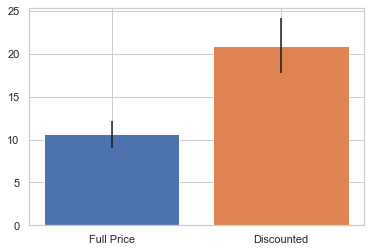


Spain PREFERS DISCOUNTS!
Sweden


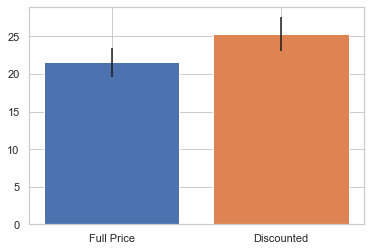

Switzerland


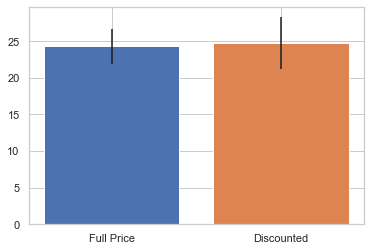

UK


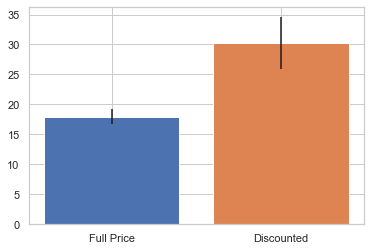


UK PREFERS DISCOUNTS!
USA


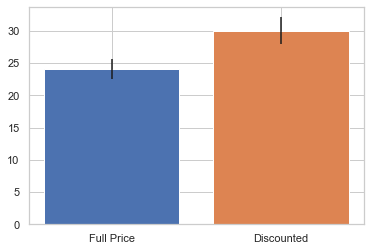


USA PREFERS DISCOUNTS!
Venezuela


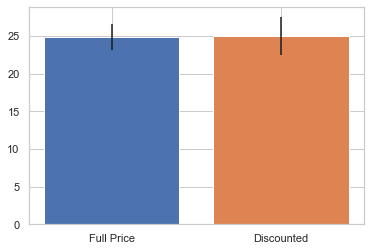

In [278]:
# Check if sample sizes allow us to ignore assumptions;
# visualize sample size comparisons for two groups (normality check)

stat_dict = {}


for k,v in countries.items():
    try:
        grp0 = df_countries.loc[v].groupby('discounted').get_group(0)['Quantity']
        grp1 = df_countries.loc[v].groupby('discounted').get_group(1)['Quantity']
        print(f"{k}")
        
        import scipy.stats as stat

        plt.bar(x='Full Price', height=grp0.mean(), yerr=stat.sem(grp0))
        plt.bar(x='Discounted', height=grp1.mean(), yerr=stat.sem(grp1))
        plt.show()
        
    except:
        pass
        
    try:
        result = stat.ttest_ind(grp0,grp1)
        if result[1] < 0.05:
            stat_dict[k] = result[1]
            print(f"\n{k} PREFERS DISCOUNTS!")
        else:
            continue
    except:
        print(f"{k} does not contain one of the groups.")

In [279]:
stat_dict

{'Argentina': 5.976619340195624e-06,
 'Canada': 0.0010297982736886485,
 'Norway': 0.04480094051665529,
 'Spain': 0.0025087181106716217,
 'UK': 0.00031794803200322925,
 'USA': 0.019868707223971476}

### Normality Test

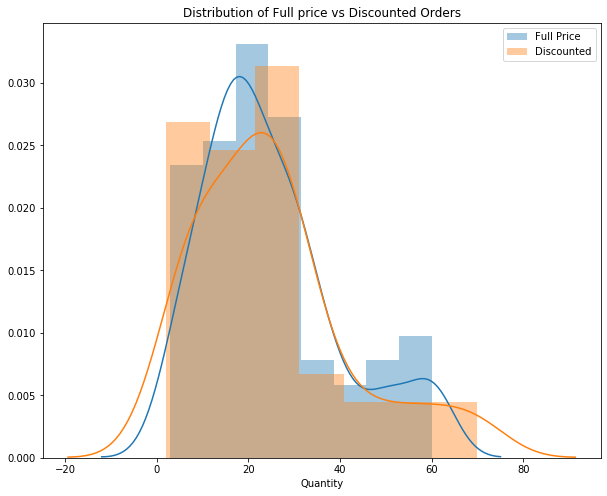

In [133]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(title="Distribution of Full price vs Discounted Orders")

sns.distplot(grp0)
sns.distplot(grp1)
ax.legend(['Full Price','Discounted'])

In [95]:
# Test for normality - D'Agostino-Pearson's normality test: scipy.stats.normaltest
stat.normaltest(grp0), stat.normaltest(grp1)

(NormaltestResult(statistic=9.316225653095811, pvalue=0.009484344125890621),
 NormaltestResult(statistic=10.255309993341813, pvalue=0.005930451108115991))

In [96]:
# Run non-parametric test (since normality test failed)
stat.mannwhitneyu(grp0, grp1)

MannwhitneyuResult(statistic=1632.5, pvalue=0.44935140740973323)

**Canada, Spain, UK and the USA have pvalues < 0.05 indicating there is a relationship between discount and order quantity and the null hypothesis is rejected for these individual countries.**

In [97]:
# test normality assumption
for k,v in countries.items():
    try:
        grp0 = df_countries.loc[v].groupby('discounted').get_group(0)['Quantity']
        grp1 = df_countries.loc[v].groupby('discounted').get_group(1)['Quantity']
        result = stat.ttest_ind(grp0,grp1)
        if result[1] < 0.05:
            print(f"\n{k} PREFERS DISCOUNTS!")
        else:
            continue
    except:
        print(f"{k} does not contain one of the groups.")

Argentina does not contain one of the groups.

Canada PREFERS DISCOUNTS!
Norway does not contain one of the groups.
Poland does not contain one of the groups.

Spain PREFERS DISCOUNTS!

UK PREFERS DISCOUNTS!

USA PREFERS DISCOUNTS!


Text(0.5, 1.0, 'Order Qty by Country: discount vs fullprice')

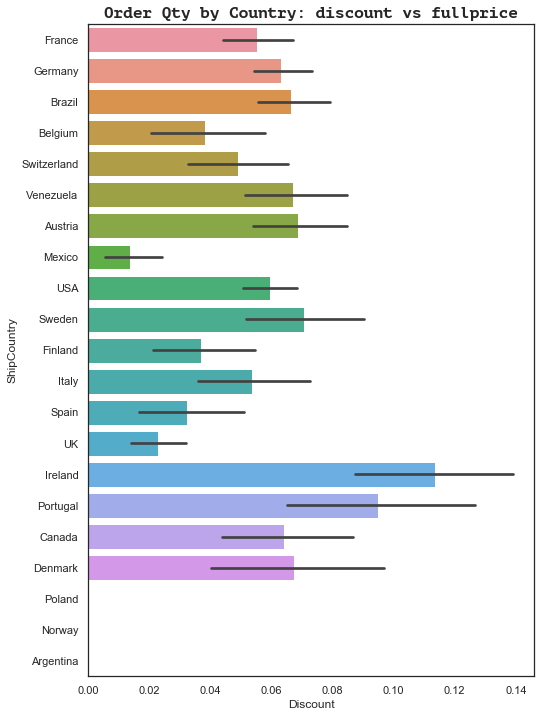

In [253]:
fig = plt.figure(figsize=(8,12))
ax = fig.gca(title="Average Order Quantity by Country")

ax = sns.barplot(x='Discount', y='ShipCountry', data=df_countries)
ax.set_title('Order Qty by Country: discount vs fullprice', fontdict={'family': 'PT Mono', 'size':16})

### Statistical Test

In [104]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols("Quantity~C(discounted)+C(ShipCountry)+C(discounted):C(ShipCountry)", data=df_countries).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 18
  'rank is %d' % (J, J_), ValueWarning)
/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 18
  'rank is %d' % (J, J_), ValueWarning)


In [103]:
# reformat scientific notation of results for easier interpretation
anova_table.style.format("{:.5f}", subset=['PR(>F)'])

,sum_sq,df,F,PR(>F)
C(discounted),9.78092e-08,1,3.07557e-10,0.99999
C(ShipCountry),101347,20,15.9341,0.00000
C(discounted):C(ShipCountry),15584.9,20,2.4503,0.00061
Residual,672930,2116,nan,nan


Although discount does not have a significant effect on countries overall (p = 0.99), there is a statistically significant relationship between order quantities and discount in some of the countries (p=0.0006).

According to the SEM bar plots and ttest statistics above, countries showing a preference for discount include:
* Spain
* UK
* Canada
* USA

In [ ]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))


# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=df_countries,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [185]:
# OVERLAPPING DENSITIES (RIDGE PLOT)
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = df_countries.Quantity
#g = np.tile(list("ABCDEFGHIJ"), 50)
g = df_countries.ShipCountry

#df = pd.DataFrame(dict(x=x, g=g))
df = pd.DataFrame(dict(x=x,g=g))

m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

TypeError: ord() expected a character, but string of length 6 found

### Effect Size

Effect size testing is unnecessary since the null hypothesis for the main question was not rejected.

Text(0.5, 1.0, 'Order Qty by Country')

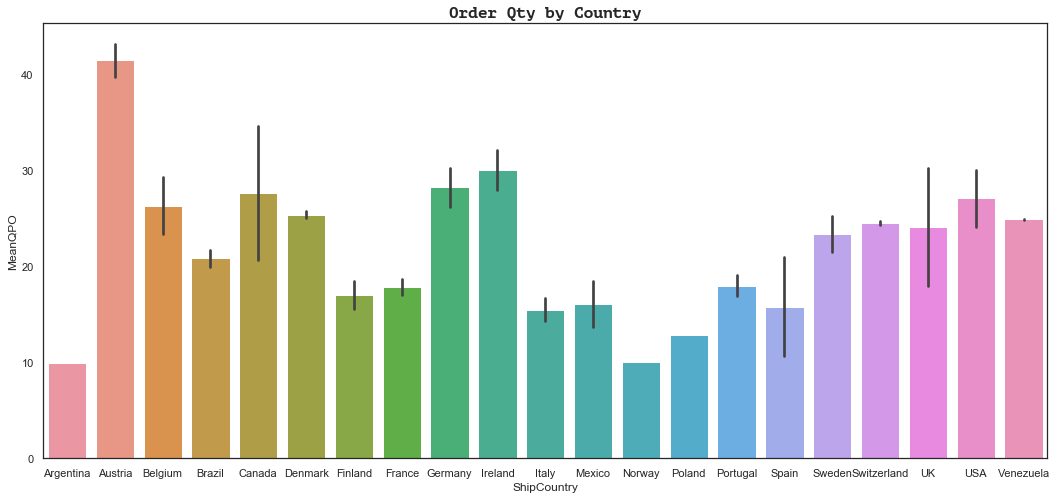

In [241]:
q1 = "SELECT ShipCountry, Count(*) as OrderCount from df_countries where discounted = 0 group by 1;"
q2 = "SELECT ShipCountry, Count(*) as OrderCount from df_countries where discounted = 1 group by 1;"

df_fpCount = pysqldf(q1)
df_dcCount = pysqldf(q2)

df_fpCount['Group'] = 'FullPrice'
df_dcCount['Group'] = 'Discount'

fig = plt.figure(figsize=(18,8))
ax = fig.gca(title="Average Order Quantity by Country")

ax = sns.barplot(x='ShipCountry', y='MeanQPO', data=country_df)
ax.set_title('Order Qty by Country', fontdict={'family': 'PT Mono', 'size':16})

### Post-hoc Tests

In [111]:
# Part 2: To what extent (percentage difference) do countries order discount vs full price
#discountry_df = df_countries[df_countries.ShipCountry.isin(['Spain','UK','USA','Canada'])]
#discountry_df.head()

In [187]:
#!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

,OrderCount
count,39.000000
mean,55.256410
std,48.722478
min,8.000000
25%,22.000000
50%,39.000000
75%,69.500000
max,210.000000


Text(0.5, 1.0, 'Count of Fullprice vs Discount Orders by Country')

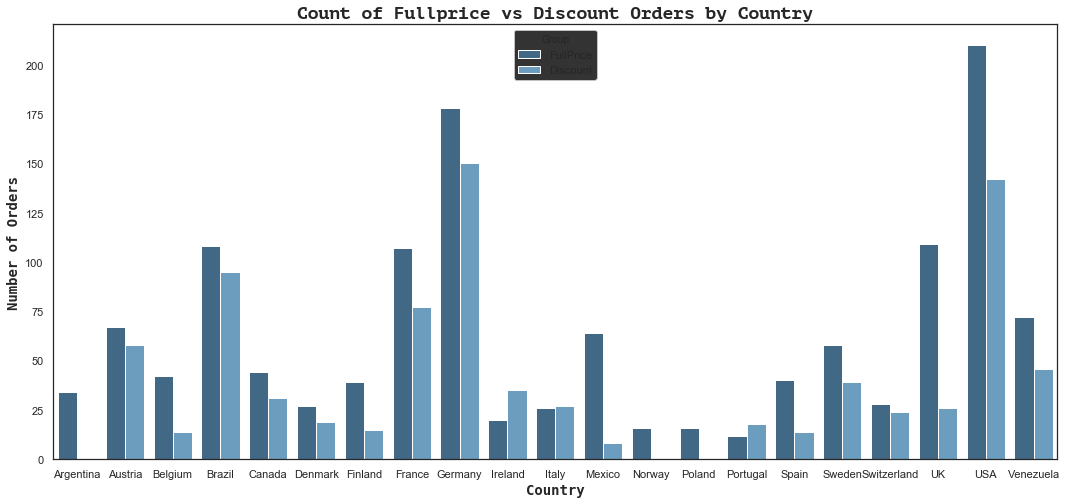

In [197]:
# Compare number of discount vs fullprice orders by country.
# Create bar plots grouped as discount vs fullprice orders by country
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,8))

q1 = "SELECT ShipCountry, Count(*) as OrderCount from df_countries where discounted = 0 group by 1;"
q2 = "SELECT ShipCountry, Count(*) as OrderCount from df_countries where discounted = 1 group by 1;"

df_fpCount = pysqldf(q1)
df_dcCount = pysqldf(q2)

df_fpCount['Group'] = 'FullPrice'
df_dcCount['Group'] = 'Discount'

df_country_count = pd.concat([df_fpCount, df_dcCount], axis=0)

display(df_country_count.describe())

#ax = sns.barplot(x='ShipCountry', y='NumOrders', data=country_df, hue='Group', palette='pastel', orient='v')
#ax.set_title('Number of Fullprice vs Discount Orders by Country', fontdict={'family': 'monospace', 'size':16})

#ax1 = sns.barplot(x='ShipCountry', y='TotalQty', data=country_df, hue='Group', palette='pastel', orient='v')
#ax1.set_title('Total Qty of Fullprice vs Discount Orders by Country', fontdict={'family': 'monospace', 'size':16})


fig = plt.figure(figsize=(18,8))
ax = fig.gca(title="Mean QPO by Country")

sns.barplot(x='ShipCountry', y='OrderCount', ax=ax, data=df_country_count, hue='Group', 
            palette='Blues_d', orient='v', ci=68, capsize=.2)

## Set Title,X/Y Labels,fonts,formatting
ax_font = {'family':'monospace','weight':'semibold','size':14}
tick_font = {'size':12,'ha':'center','rotation':45}
t_label = "Count of Fullprice vs Discount Orders by Country"
t_font = {'family': 'PT Mono', 'size':18}

ax.set_ylabel("Number of Orders", fontdict=ax_font)
ax.set_xlabel("Country", fontdict=ax_font)
#ax.set_title('Average Order Quantity by Country: Fullprice vs Discount', fontdict={'family': 'PT Mono', 'size':16})
ax.set_title(t_label, fontdict=t_font)


According to the plot above, the actual number of discounted orders is lower than the number of full price orders. Let's compare the sum of quantities for these orders in each group.

,OrderCount
count,39.000000
mean,55.256410
std,48.722478
min,8.000000
25%,22.000000
50%,39.000000
75%,69.500000
max,210.000000


Text(0.5, 1.0, 'Count of Fullprice vs Discount Orders by Country')

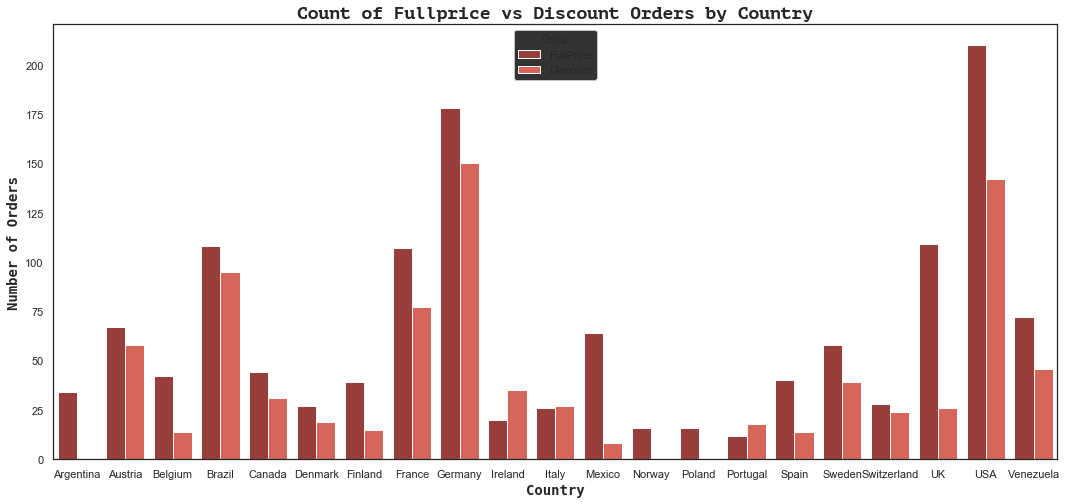

In [205]:
# Compare number of discount vs fullprice orders by country.
# Create bar plots grouped as discount vs fullprice orders by country
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,8))

q1 = "SELECT ShipCountry, Count(*) as OrderCount from df_countries where discounted = 0 group by 1;"
q2 = "SELECT ShipCountry, Count(*) as OrderCount from df_countries where discounted = 1 group by 1;"

df_fpCount = pysqldf(q1)
df_dcCount = pysqldf(q2)

df_fpCount['Group'] = 'FullPrice'
df_dcCount['Group'] = 'Discount'

df_country_count = pd.concat([df_fpCount, df_dcCount], axis=0)

display(df_country_count.describe())

#ax = sns.barplot(x='ShipCountry', y='NumOrders', data=country_df, hue='Group', palette='pastel', orient='v')
#ax.set_title('Number of Fullprice vs Discount Orders by Country', fontdict={'family': 'monospace', 'size':16})

#ax1 = sns.barplot(x='ShipCountry', y='TotalQty', data=country_df, hue='Group', palette='pastel', orient='v')
#ax1.set_title('Total Qty of Fullprice vs Discount Orders by Country', fontdict={'family': 'monospace', 'size':16})


fig = plt.figure(figsize=(18,8))
ax = fig.gca(title="Mean QPO by Country")

sns.barplot(x='ShipCountry', y='OrderCount', ax=ax, data=df_country_count, hue='Group', palette='Reds_d', 
            orient='v', ci=68, capsize=.2)

## Set Title,X/Y Labels,fonts,formatting
ax_font = {'family':'monospace','weight':'semibold','size':14}
tick_font = {'size':12,'ha':'center','rotation':45}
t_label = "Count of Fullprice vs Discount Orders by Country"
t_font = {'family': 'PT Mono', 'size':18}

ax.set_ylabel("Number of Orders", fontdict=ax_font)
ax.set_xlabel("Country", fontdict=ax_font)
#ax.set_title('Average Order Quantity by Country: Fullprice vs Discount', fontdict={'family': 'PT Mono', 'size':16})
ax.set_title(t_label, fontdict=t_font)


This still doesn't tell us much about whether or not these countries prefer discounts (tend to order more products) or not - in order to get better insight, we need to look at the average order size (mean quantities per order) for each group.

,MeanQPO
count,39.000000
mean,22.596281
std,7.620086
min,9.970588
25%,17.458458
50%,21.750000
75%,25.985539
max,43.172414


Text(0.5, 1.0, 'Average Order Quantity by Country: Fullprice vs Discount')

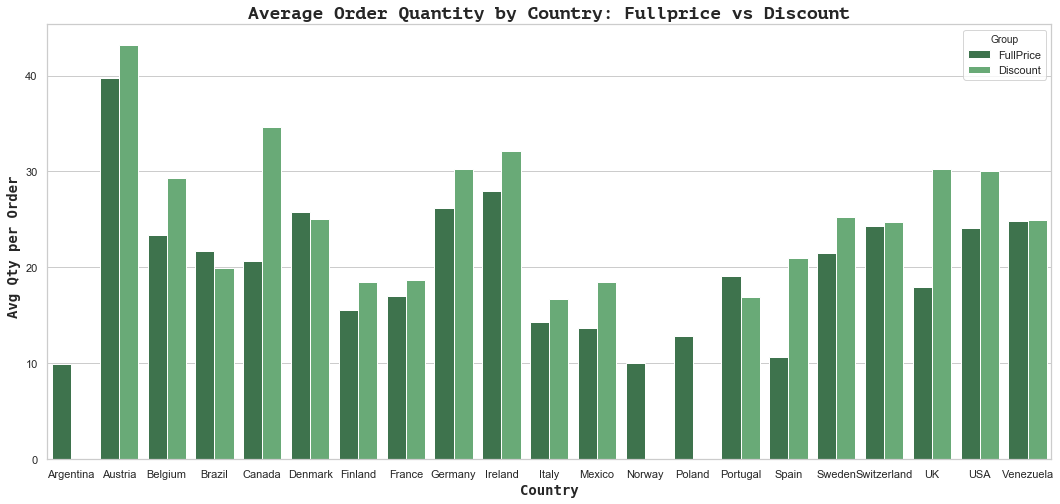

In [302]:
# Compare number of discount vs fullprice orders by country.
# Create bar plots grouped as discount vs fullprice orders by country
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,8))

#q1 = "SELECT ShipCountry, Count(*) as NumOrders, SUM(Quantity) as TotalQty, AVG(Quantity) as MeanQPO from df_countries where discounted = 0 group by 1;"
#q2 = "SELECT ShipCountry, Count(*) as NumOrders, SUM(Quantity) as TotalQty, AVG(Quantity) as MeanQPO from df_countries where discounted = 1 group by 1;"

q1 = "SELECT ShipCountry, AVG(Quantity) as MeanQPO from df_countries where discounted = 0 group by 1;"
q2 = "SELECT ShipCountry, AVG(Quantity) as MeanQPO from df_countries where discounted = 1 group by 1;"

fullprice_df = pysqldf(q1)
discount_df = pysqldf(q2)

fullprice_df['Group'] = 'FullPrice'
discount_df['Group'] = 'Discount'

country_df = pd.concat([fullprice_df, discount_df], axis=0)

display(country_df.describe())

#ax = sns.barplot(x='ShipCountry', y='NumOrders', data=country_df, hue='Group', palette='pastel', orient='v')
#ax.set_title('Number of Fullprice vs Discount Orders by Country', fontdict={'family': 'monospace', 'size':16})

#ax1 = sns.barplot(x='ShipCountry', y='TotalQty', data=country_df, hue='Group', palette='pastel', orient='v')
#ax1.set_title('Total Qty of Fullprice vs Discount Orders by Country', fontdict={'family': 'monospace', 'size':16})


fig = plt.figure(figsize=(18,8))
ax = fig.gca(title="Mean QPO by Country")

sns.barplot(x='ShipCountry', y='MeanQPO', ax=ax, data=country_df, hue='Group', palette='Greens_d', 
            orient='v', capsize=.2)

## Set Title,X/Y Labels,fonts,formatting
ax_font = {'family':'monospace','weight':'semibold','size':14}
tick_font = {'size':12,'ha':'center','rotation':45}
t_label = "Average Order Quantity by Country: Fullprice vs Discount"
t_font = {'family': 'PT Mono', 'size':18}

ax.set_ylabel("Avg Qty per Order ", fontdict=ax_font)
ax.set_xlabel("Country", fontdict=ax_font)
#ax.set_title('Average Order Quantity by Country: Fullprice vs Discount', fontdict={'family': 'PT Mono', 'size':16})
ax.set_title(t_label, fontdict=t_font)


The above plots indicate that when a discount is offered, certain countries order higher quantities of products. Let's look at the values to determine what percentage more they purchase when an order is discounted.

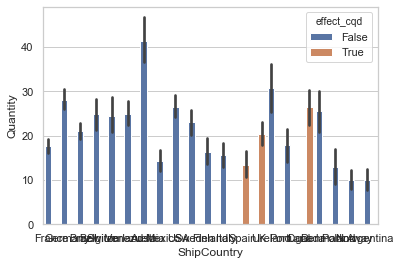

In [309]:
# add new col for countries where discount has significant effect

df_countries['effect_cqd'] = df_countries['ShipCountry'].isin(['Spain', 'UK', 'US', 'Canada'])
ax = sns.barplot(x='ShipCountry', y='Quantity', hue='effect_cqd', data=df_countries)


In [308]:

sns.catplot(x='effect_cqd', y='meanQPO',
                hue='effect_cqd', data='df_countries')
                 
fig = plt.figure(figsize=(18,8))
ax = fig.gca(title="Mean QPO by Country")

sns.barplot(x='ShipCountry', y='MeanQPO', ax=ax, data=country_df, hue='Group', palette='Greens_d', 
            orient='v', capsize=.2)

# countplot : Show the counts of observations in each categorical bin.    
# pointplot : Show point estimates and confidence intervals using scatterplot
#             glyphs.    
# catplot : Combine a categorical plot with a class:`FacetGrid`.

AttributeError: 'str' object has no attribute 'get'

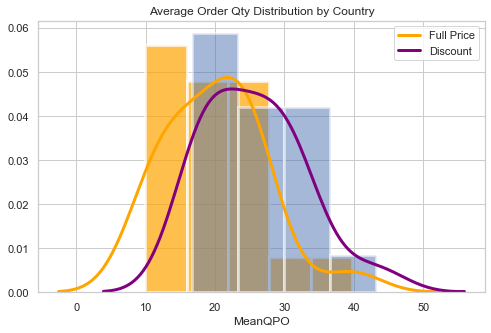

In [298]:
sns.set_style="whitegrid"

fig = plt.figure(figsize=(8,5))

ax = fig.gca(title="Average Order Qty Distribution by Country")

sns.distplot(fullprice_df.MeanQPO, ax=ax, kde=True,rug_kws={"color": "orange"},
                  kde_kws={"color": "orange", "lw": 3, "label": "Full Price"},
                  hist_kws={"linewidth": 3,
                            "alpha": 0.7, "color": "orange"})
sns.distplot(discount_df.MeanQPO, ax=ax, kde=True,rug_kws={"color": "purple"},
                  kde_kws={"color": "purple", "lw": 3, "label": "Discount"},
                  hist_kws={"linewidth": 3,
                            "alpha": 0.5, "color": "b"})

In [300]:
# q0 = "SELECT ShipCountry, AVG(Quantity) as fpmean_qty from discountry_df where discounted = 0 group by 1;"
# q1 = "SELECT ShipCountry, AVG(Quantity) as dcmean_qty from discountry_df where discounted = 1 group by 1;"
# q3 = "SELECT ShipCountry, AVG(Quantity) as mean_qty from discountry_df group by 1;"

# fp = pysqldf(q0)
# dc = pysqldf(q1)
# mean_qty = pysqldf(q3)

# country_mean_qty = fp
# country_mean_qty['dcmean_qty'] = dc['dcmean_qty']

# country_mean_qty['mean_diff'] = country_mean_qty.dcmean_qty - country_mean_qty.fpmean_qty
# country_mean_qty['mean_qty'] = mean_qty['mean_qty']

# #display(pysqldf(q0), pysqldf(q1))

Text(0.5, 1.0, 'Order Count by Country')

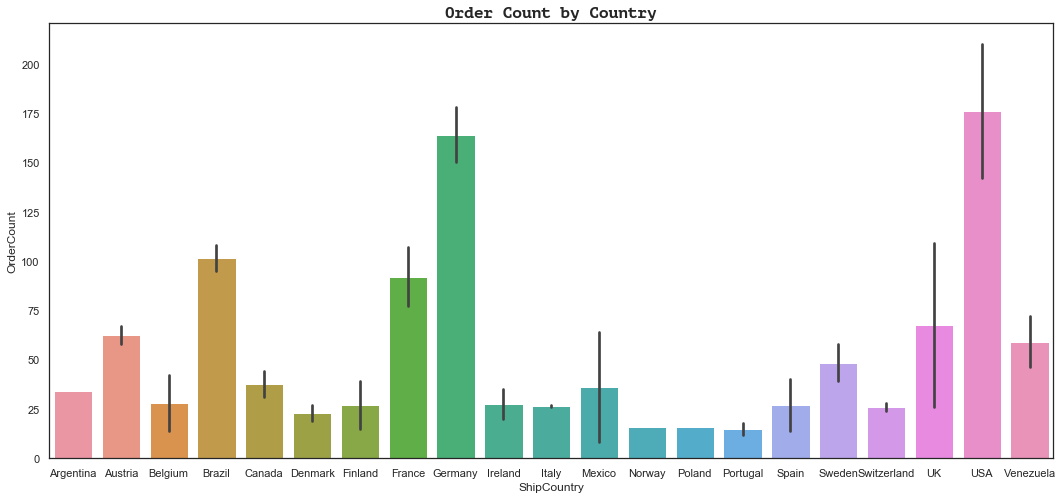

In [244]:
q1 = "SELECT ShipCountry, Count(*) as OrderCount from df_countries where discounted = 0 group by 1;"
q2 = "SELECT ShipCountry, Count(*) as OrderCount from df_countries where discounted = 1 group by 1;"

df_fpCount = pysqldf(q1)
df_dcCount = pysqldf(q2)

df_fpCount['Group'] = 'FullPrice'
df_dcCount['Group'] = 'Discount'

df_countryCount = pd.concat([df_fpCount, df_dcCount])

fig = plt.figure(figsize=(18,8))
ax = fig.gca(title="Average Order Quantity by Country")

ax = sns.barplot(x='ShipCountry', y='OrderCount', data=df_countryCount)
ax.set_title('Order Count by Country', fontdict={'family': 'PT Mono', 'size':16})

In [62]:
country_mean_qty                           

,ShipCountry,fpmean_qty,dcmean_qty,mean_diff,mean_qty
0,Canada,20.704545,34.612903,13.908358,26.453333
1,Spain,10.625000,20.928571,10.303571,13.296296
2,UK,17.944954,30.230769,12.285815,20.311111
3,USA,24.123810,30.028169,5.904359,26.505682


In [251]:
# insert boolean column showing whether or not an order was discounted
df_countries['discounted'] = np.where(df_orderDetail['Discount'] == 0.0, 0, 1)

q1 = "SELECT ShipCountry, Average(Quantity) as MeanQPO from countries_dc where discounted = 0 group by 1;"
q2 = "SELECT ShipCountry, Count(*) as OrderCount from countries_dc where discounted = 1 group by 1;"

df_fpq = pysqldf(q1)
df_dcq = pysqldf(q2)

df_fpq['Group'] = 'FullPrice'
df_dcq['Group'] = 'Discount'

dcq_countries = pd.concat([df_fpCount, df_dcCount])

fig = plt.figure(figsize=(18,8))
ax = fig.gca(title="Average Order Quantity by Country")

ax = sns.barplot(x='ShipCountry', y='OrderCount', data=dcq_countries)
ax.set_title('Order Count by Country', fontdict={'family': 'PT Mono', 'size':16})

SyntaxError: invalid syntax (<ipython-input-251-a00e7df94199>, line 1)

## Results

At alpha = 0.05 significance level, countries overall have no relationship with order quantity for discount vs full price and the null hypothesis is not rejected.

However, for certain individual countries (Spain, Canada, UK, USA), the null hypothesis is rejected with p-values below 0.05.

# H3: Region & Revenue

**Does average revenue per order vary between different customer regions?**

**If so, how do the regions rank in terms of average revenue per order?**

*Additional questions to explore:*
**Does geographic distance between distributor and shipcountry have an effect on order quantity?**
**Does shipping cost have an effect on order quantity?**

## Hypotheses

$H_0$ the average revenue per order is the same between different customer regions.

$H_1$ Alternate hypothesis: the average revenue per order is different (higher or lower) across different customer regions.

*The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) is = 0.05.*

## EDA

Select the proper dataset for analysis, generate data groups for testing, perform EDA.

### Select

In [312]:
# Extract revenue per product per order
cur.execute("""SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
FROM Customer c
JOIN 'Order' o ON c.Id = o.CustomerId
JOIN OrderDetail od USING(OrderId);""")
df = pd.DataFrame(cur.fetchall())
df. columns = [i[0] for i in cur.description]
print(len(df))
df.head()

2078


,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [257]:
# Get total revenue per order

df['Revenue'] = df.Quantity * df.UnitPrice * (1-df.Discount)

In [258]:
# Drop unnecessary columns
df.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

### Group

In [259]:
# Group data by order and get average revenue per order for each region
df_region = df.groupby(['Region', 'OrderId'])['Revenue'].mean().reset_index()
# drop Order Id (no longer necessary)
df_region.drop('OrderId', axis=1, inplace=True)
# check changes
df_region.head()

,Region,Revenue
0,British Isles,239.70
1,British Isles,661.25
2,British Isles,352.40
3,British Isles,258.40
4,British Isles,120.20


In [260]:
# Explore sample sizes before testing: n > 30 to pass assumptions
df_region.groupby('Region').count()

,Revenue
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


Some of the sample sizes are too small to ignore assumptions of normality. We can combine some regions to meet the required threshold of n > 30.

In [261]:
# Group sub-regions together to create sample sizes adequately large for ANOVA testing  (min 30)

# Group Scandinavia, Northern and Eastern Europe
df_region.loc[(df_region.Region == 'Scandinavia') | (df_region.Region == 'Eastern Europe') | (df_region.Region == 'Northern Europe'), 'Region'] = 'North Europe'

# Group South and Central America
df_region.loc[(df_region.Region == 'South America') | (df_region.Region == 'Central America'), 'Region'] = 'South Americas'

# Review sizes of new groups
df_region.groupby('Region').count()

,Revenue
Region,
British Isles,75
North America,152
North Europe,90
South Americas,148
Southern Europe,64
Western Europe,272


### Explore

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()

sns.distplot(grp0)
sns.distplot(grp1)
ax.legend(['Full Price','Discounted'])

# Plot number of orders, total revenue, and average revenue per order by region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
# Number of orders
df_region.groupby(['Region'])['Revenue'].count().plot(kind='barh', ax=ax1, color='b')

# Total Revenue
df_region.groupby(['Region'])['Revenue'].sum().plot(kind='barh', ax=ax2, color='r')

# Average Revenue
df_region.groupby(['Region'])['Revenue'].mean().plot(kind='barh', ax=ax3, color='g')

# Label plots and axes
ax1.set_title('Total Orders')
ax1.set_ylabel('')
ax2.set_title('Total Revenue in US$')
ax2.set_ylabel('')
ax3.set_title('Average Revenue per Order US$')
ax3.set_ylabel('')

fig.subplots_adjust(hspace=0.4);

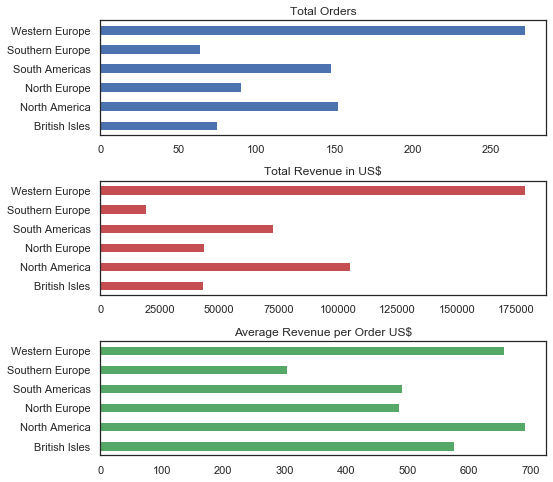

In [262]:
# Plot number of orders, total revenue, and average revenue per order by region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
# Number of orders
df_region.groupby(['Region'])['Revenue'].count().plot(kind='barh', ax=ax1, color='b')

# Total Revenue
df_region.groupby(['Region'])['Revenue'].sum().plot(kind='barh', ax=ax2, color='r')

# Average Revenue
df_region.groupby(['Region'])['Revenue'].mean().plot(kind='barh', ax=ax3, color='g')

# Label plots and axes
ax1.set_title('Total Orders')
ax1.set_ylabel('')
ax2.set_title('Total Revenue in US$')
ax2.set_ylabel('')
ax3.set_title('Average Revenue per Order US$')
ax3.set_ylabel('')

fig.subplots_adjust(hspace=0.4);

The graphs show that Western Europe is the region with the greatest number of orders, and also has the greatest total revenue. However, North America has the most expensive order on average (followed by Western Europe). Southern and Eastern Europe has the lowest number of orders, lowest total revenue, and cheapest order on average. The third graph lent support to the alternate hypothesis that there are significant differences in average order revenue between regions. 

## Test

### Sample Size
Check if sample sizes allow us to ignore assumptions of normality

In [ ]:
# countplot : Show the counts of observations in each categorical bin.    
# pointplot : Show point estimates and confidence intervals using scatterplot
#             glyphs.    
# catplot : Combine a categorical plot with a class:`FacetGrid`.

Text(0.5, 1.0, 'Average Order Revenue by Region')

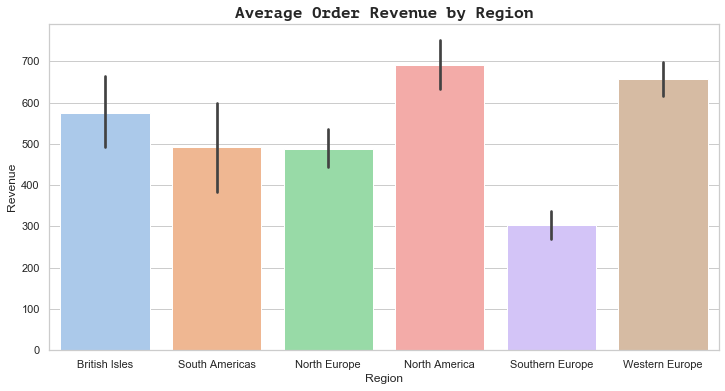

In [290]:
# visualize sample size comparisons, check normality (pvals)
fig = plt.figure(figsize=(12,6))
ax = fig.gca()

ax = sns.barplot(x='Region', y='Revenue', data=df_region, ci=68, palette="pastel", hue=)
ax.set_title('Average Order Revenue by Region', fontdict={'family': 'PT Mono', 'size':16})

NormaltestResult(statistic=339.9576854638769, pvalue=1.5105202827923603e-74)
NormaltestResult(statistic=43.81961700014593, pvalue=3.0527487976334264e-10)
NormaltestResult(statistic=77.63787783979987, pvalue=1.3840412490785474e-17)
NormaltestResult(statistic=311.45736288265334, pvalue=2.3328830945007275e-68)
NormaltestResult(statistic=136.230976580461, pvalue=2.617093889288348e-30)
NormaltestResult(statistic=105.41475929189932, pvalue=1.286695743223332e-23)


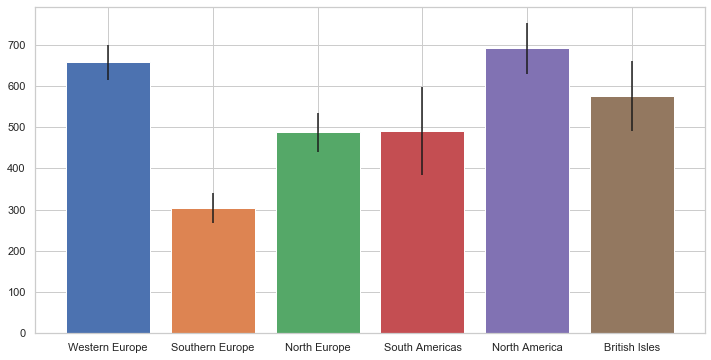

In [285]:
# Check if sample sizes allow us to ignore assumptions of normality

# visualize sample size comparisons, check normality (pvals)
regions = ['Western Europe', 'Southern Europe', 'North Europe', 'South Americas', 'North America', 'British Isles']
fig = plt.figure(figsize=(12,6))
for region in regions:
    grp = df_region.groupby('Region').get_group(region)['Revenue']
    plt.bar(x=region, height=grp.mean(), yerr=stat.sem(grp))
    print(stat.normaltest(grp))
plt.show()

### Normality

### Statistical

In [264]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols("Revenue~C(Region)+Revenue:C(Region)", data=df_region).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
# reformat scientific notation of results for easier interpretation
anova_table.style.format("{:.5f}", subset=['PR(>F)'])

,sum_sq,df,F,PR(>F)
C(Region),1.03486e+07,5,3.98262e+30,0.00000
Revenue:C(Region),5.34162e+08,6,1.71309e+32,0.00000
Residual,4.10034e-22,789,nan,nan


In [265]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_region['Revenue'].values
labels = df_region['Region'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,British Isles,North America,116.4615,0.9,-213.9625,446.8854,False
1,British Isles,North Europe,-88.1693,0.9,-454.2704,277.9318,False
2,British Isles,South Americas,-84.2501,0.9,-416.146,247.6458,False
3,British Isles,Southern Europe,-271.7815,0.3745,-670.2535,126.6904,False
4,British Isles,Western Europe,81.6889,0.9,-223.7052,387.083,False
5,North America,North Europe,-204.6308,0.4191,-516.0716,106.8101,False
6,North America,South Americas,-200.7115,0.2778,-471.1191,69.6961,False
7,North America,Southern Europe,-388.243,0.0191,-737.1631,-39.3228,True
8,North America,Western Europe,-34.7725,0.9,-271.9032,202.3581,False
9,North Europe,South Americas,3.9193,0.9,-309.0829,316.9214,False


North America and Southern Europe:  pval = 0.01, mean diff: -388.24

Southern Europe and Western Europe: pval = 0.02, mean diff: 353.4704

### Effect Size

Cohen's D

In [267]:
northamerica = df_region.loc[df_region['Region'] == 'North America']
southerneurope = df_region.loc[df_region['Region'] == 'Southern Europe']
westerneurope = df_region.loc[df_region['Region'] == 'Western Europe']

na_se = Cohen_d(northamerica.Revenue, southerneurope.Revenue)
se_we = Cohen_d(southerneurope.Revenue, westerneurope.Revenue)

print(na_se, se_we)

0.5891669383438923 -0.5462384714677272


## Post-Hoc Tests

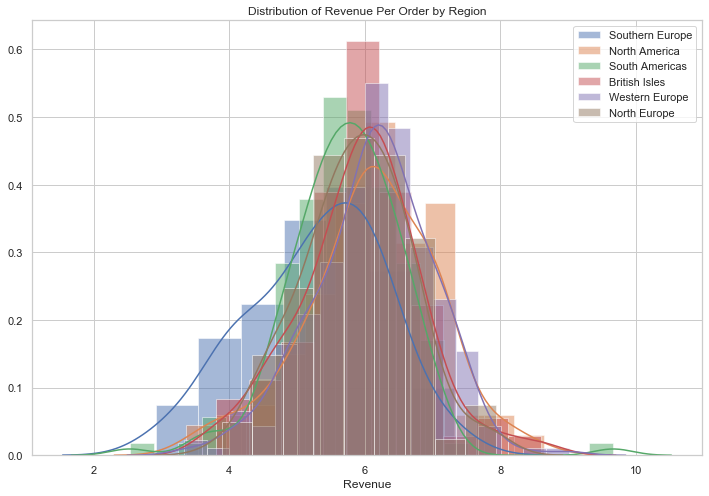

In [274]:
# log-transforming revenue per order
logRegion_df = df_region.copy()
logRegion_df['Revenue'] = np.log(df_region['Revenue'])

# Plotting the distributions for the log-transformed data
sns.set_style("whitegrid")

fig = plt.figure(figsize=(12,8))
ax = fig.gca(title="Distribution of Revenue Per Order by Region")

for region in set(logRegion_df.Region):
    region_group = logRegion_df.loc[logRegion_df['Region'] == region]
    sns.distplot(region_group['Revenue'], hist_kws=dict(alpha=0.5), label=region)
    ax.legend()
    ax.set_label('Revenue per Order (log-transformed)')

In [311]:
# The data is more normally distributed, and variances from the mean were more similar. 
# run an ANOVA test:

# Fitting a model of revenue per order on Region categories - ANOVA table
lm = ols('Revenue ~ C(Region)', logRegion_df).fit()
sm.stats.anova_lm(lm, typ=2)


,sum_sq,df,F,PR(>F)
C(Region),48.004167,5.0,12.076998,2.713885e-11
Residual,631.999979,795.0,NaN,NaN


## Results

At an alpha level of 0.05 significance, revenue does vary between regions and therefore the null hypothesis is rejected.



The ANOVA table above revealed that the p-value is lower than the alpha value of 0.05. Therefore I was able to reject the null hypothesis and accept the alternate hypothesis. There are statistically significant differences in average order value between different regions, i.e. customers from different parts of the world spend different amounts of money on their orders, on average.
Conclusions
Business insights:
There are statistically significant differences in the average revenue per order from customers from different regions.
Western European customers place the most orders, and are the single biggest contributors to Northwind’s bottom line. However, although North American customers have placed roughly half as many orders as those from Western Europe, they spend more per order, on average.
The difference between the region with the most expensive orders on average (North America, $1,945.93) and the region with the least expensive orders (Southern and Eastern Europe, $686.73) is $1,259.20, or 2.8 times more for orders from North America.
Southern and Eastern Europe has the smallest number of orders, the lowest total revenue, and the lowest average revenue per order.
North American customers have placed a similar number of orders to those from South and Central America, but their average expenditure per order is 1.8 times higher.
Potential business actions and directions for future work:
If Northwind was looking to focus on more profitable customers, a potential action would be to stop serving customers in Southern and Eastern Europe, and to focus more on customers in Western Europe and North America.
However, further analysis would be needed to confirm these findings. For example, it might be the case that some more expensive products are only available in certain regions.

---

### H4: Season+Quantity:ProductCategory

1: **Does time of year (month) have an effect on order quantity overall?**

2: **Does time of year (month) have an effect on order quantity of specific product categories?**

3: **Does time of year (month) have an effect on order quantity by region?**

## Hypotheses
    
* $𝐻_1$  : Time of year has a statistically significant effect on average quantity per order.

* $𝐻_0$ : Time of year has no relationship with average quantity per order.

## EDA
- Select proper dataset for analysis: orderDetail, order
- Generate data groups for testing: number of orders per month, order quantity per month
- Explore data (sample sizes, distribution/density)

### Select

In [87]:
df_month = df_orderDetail.merge(df_order, on='OrderId', copy=True)
df_month.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD,CustomerId,EmployeeId,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,0,0.0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,0,0.0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,0,0.0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,0,0.0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,0,0.0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [88]:
pd.to_datetime(df_month['OrderDate']).head()

0   2012-07-04
1   2012-07-04
2   2012-07-04
3   2012-07-05
4   2012-07-05
Name: OrderDate, dtype: datetime64[ns]

In [89]:
pd.to_datetime(df_month['OrderDate'], format='%Y/%m/%d').head()

0   2012-07-04
1   2012-07-04
2   2012-07-04
3   2012-07-05
4   2012-07-05
Name: OrderDate, dtype: datetime64[ns]

### Group

In [90]:
df_month['OrderMonth'] = pd.DatetimeIndex(df_month['OrderDate']).month
df_month['OrderYear'] = pd.DatetimeIndex(df_month['OrderDate']).year
df_month.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD,CustomerId,EmployeeId,...,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,OrderMonth,OrderYear
0,10248/11,10248,11,14.0,12,0.0,0,0.0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
1,10248/42,10248,42,9.8,10,0.0,0,0.0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
2,10248/72,10248,72,34.8,5,0.0,0,0.0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
3,10249/14,10249,14,18.6,9,0.0,0,0.0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012
4,10249/51,10249,51,42.4,40,0.0,0,0.0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012


In [95]:
# create new col for revenue
df_month['Revenue'] = df_month.UnitPrice * df_month.Quantity * (1 - df_month.Discount)
df_month.Revenue.mean()

587.374960324826

In [94]:
# create seasonal-based dataframe with only columns we need
#keep_cols = ['OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'ShipCountry', 'OrderMonth', 'OrderYear', 'Season']
drop_cols = ['Id', 'discounted', 'OQD', 'CustomerId', 'EmployeeId', 'Freight', 'OrderDate', 'RequiredDate', 'ShippedDate', 'ShipVia', 'ShipName', 'ShipAddress', 'ShipCity', 'ShipRegion', 'ShipPostalCode']
df_month.drop(drop_cols, axis=1, inplace=True)
df_month.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,ShipCountry,OrderMonth,OrderYear
0,10248,11,14.0,12,0.0,France,7,2012
1,10248,42,9.8,10,0.0,France,7,2012
2,10248,72,34.8,5,0.0,France,7,2012
3,10249,14,18.6,9,0.0,Germany,7,2012
4,10249,51,42.4,40,0.0,Germany,7,2012


In [91]:
mqpo_m = df_month.groupby('OrderMonth')['Quantity'].mean()

### Explore

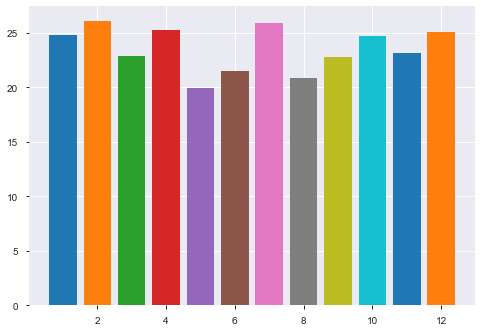

In [93]:
# plot average order quantities by month
for k,v in mqpo_m.items():
    plt.bar(x=k, height=v)

## Test

### Sample Size

In [549]:

# Check if sample sizes allow us to ignore assumptions;
# visualize sample size comparisons for two groups (normality check)


In [96]:
# Anova Test - Season + Quantity ()

import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols("Quantity~C(OrderMonth)+Quantity:C(OrderMonth)", data=df_month).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
# reformat scientific notation of results for easier interpretation
anova_table.style.format("{:.5f}", subset=['PR(>F)'])

,sum_sq,df,F,PR(>F)
C(OrderMonth),7395.98,11,2.94204e+29,0.00000
Quantity:C(OrderMonth),772004,12,2.81504e+31,0.00000
Residual,4.87009e-24,2131,nan,nan


In [557]:
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

[Text(-40.0, 0, '−40'),
 Text(-20.0, 0, '−20'),
 Text(0.0, 0, '0'),
 Text(20.0, 0, '20'),
 Text(40.0, 0, '40'),
 Text(60.0, 0, '60'),
 Text(80.0, 0, '80'),
 Text(100.0, 0, '100'),
 Text(120.0, 0, '120'),
 Text(140.0, 0, '140'),
 Text(160.0, 0, '160')]

### Normality

If you have 2-9 groups, each group should be greater than 15.
If you have 10-12 groups, each group should be greater than 20.

If the mean accurately represents the center of your distribution and your sample size is large enough, consider a parametric test because they are more powerful.

If the median better represents the center of your distribution, consider the nonparametric test even when you have a large sample.

Finally, if you have a very small sample size, you might be stuck using a nonparametric test.

Your chance of detecting a significant effect when one exists can be very small when you have both a small sample size and you need to use a less efficient nonparametric test!

### Statistical

In [97]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_month['Quantity'].values
labels = df_month['OrderMonth'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,1,2,1.3492,0.9,-4.6052,7.3037,False
1,1,3,-1.8729,0.9,-7.4759,3.73,False
2,1,4,0.5014,0.9,-5.0704,6.0733,False
3,1,5,-4.852,0.358,-11.2668,1.5627,False
4,1,6,-3.2421,0.9,-11.428,4.9438,False
...,...,...,...,...,...,...,...
61,9,11,0.3585,0.9,-6.73,7.4471,False
62,9,12,2.2267,0.9,-4.4923,8.9457,False
63,10,11,-1.5082,0.9,-8.3215,5.3051,False
64,10,12,0.3599,0.9,-6.068,6.7878,False


## Results

At a significance level of alpha = 0.05, we reject the null hypothesis which states there is no relationship between time of year (season) and sales revenue or volume of units sold. 

# Conclusion + Strategic Recommendations

- Conclusion & Strategic Recommendations
    1. 5% is the minimum discount level needed to produce maximum results. 
    - C: Offering discount levels < or > 5% either:
        a) has no effect on sales revenue and is therefore pointless
        b) increases loss in revenue despite higher order quantities that could have otherwise been achieved at only 5% discount (thereby maximizing revenue capture/minimizing loss).
    - R: Stop offering any discount other than 5%. 
    
    2. Continue to offer discounts in countries where they are effective in producing significantly higher order quantities. Stop offering discounts to countries where there is no effect on order quantities in order to minimize lost revenue. 
    
    3. Focus sales and marketing efforts in regions that produce highest revenue; consider  
    
    4.  


- Future Work
    * A. Gather and analyze critical missing data on customer types; investigate possible relationships between customer types and product categories (i.e. do certain customer types purchase certain 
    * C. Investigate possible relationship between regional revenues and shipping cost (i.e. is there a relationship between source (distributor) and destination (shipcountry) that might explain lower revenues in regions that are farther away in physical/geographic distance. 

# Future Work

Questions to explore in future analyses might include:

1. Build a product recommendation tool

2. Create discounts or free shipping offers to increase sales volumes past a certain threshold.
- Shipping Costs and Order Quantities/Sales Revenue
*Does shipping cost (freight) have a statistically significant effect on quantity? If so, at what level(s) of shipping cost?*

3. Customer Type and Product Category

*Is there a relationship between type of customer and certain product categories? If so, we can run more highly targeted sales and marketing programs for increasing sales of certain products to certain market segments.* 



# metricks

1. What were the top 3 selling products overall?
2. Top 3 selling products by country?
3. Top 3 selling products by region?
4. How did we do in sales for each product category?
5. Can we group customers into customer types (fill the empty database) and build a product recommendation tool?

In [455]:
# Extract revenue per product category
cur.execute("""SELECT o.OrderId, o.CustomerId, od.ProductId, od.Quantity, od.UnitPrice, 
                od.Quantity*od.UnitPrice*(1-Discount) as Revenue, p.CategoryId, c.CategoryName
                FROM 'Order' o
                JOIN OrderDetail od 
                ON o.OrderId = od.OrderId
                JOIN Product p 
                ON od.ProductId = p.Id
                JOIN Category c
                ON p.CategoryId = c.Id
                ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
print(len(df))
df.head(8)

2155


,OrderId,CustomerId,ProductId,Quantity,UnitPrice,Revenue,CategoryId,CategoryName
0,10248,VINET,11,12,14.0,168.0,4,Dairy Products
1,10248,VINET,42,10,9.8,98.0,5,Grains/Cereals
2,10248,VINET,72,5,34.8,174.0,4,Dairy Products
3,10249,TOMSP,14,9,18.6,167.4,7,Produce
4,10249,TOMSP,51,40,42.4,1696.0,7,Produce
5,10250,HANAR,41,10,7.7,77.0,8,Seafood
6,10250,HANAR,51,35,42.4,1261.4,7,Produce
7,10250,HANAR,65,15,16.8,214.2,2,Condiments


In [465]:
# Group data by Category and get sum total revenue for each
df_category = df.groupby(['CategoryName'])['Revenue'].sum().reset_index()
df_category

,CategoryName,Revenue
0,Beverages,267868.1800
1,Condiments,106047.0850
2,Confections,167357.2250
3,Dairy Products,234507.2850
4,Grains/Cereals,95744.5875
5,Meat/Poultry,163022.3595
6,Produce,99984.5800
7,Seafood,131261.7375


In [473]:
df.CategoryId.value_counts()

1    404
4    366
3    334
8    330
2    216
5    196
6    173
7    136
Name: CategoryId, dtype: int64

In [470]:
# Explore sample sizes before testing
categories = df.groupby('CategoryName').groups
categories.keys()

dict_keys(['Beverages', 'Condiments', 'Confections', 'Dairy Products', 'Grains/Cereals', 'Meat/Poultry', 'Produce', 'Seafood'])

In [460]:
df_category.loc[df_category['CategoryName'] == 'Beverages']['Revenue'].sum()

267868.18

In [476]:
#create dict of months and order quantity totals
rev_per_cat = {}

for k,v in categories.items():
    rev = df_category.loc[df_category['CategoryName'] == k]['Revenue'].sum()
    rev_per_cat[k] = rev

rev_per_cat

{'Beverages': 267868.17999999993,
 'Condiments': 106047.08500000002,
 'Confections': 167357.22499999995,
 'Dairy Products': 234507.285,
 'Grains/Cereals': 95744.58750000001,
 'Meat/Poultry': 163022.3595,
 'Produce': 99984.57999999999,
 'Seafood': 131261.73750000002}

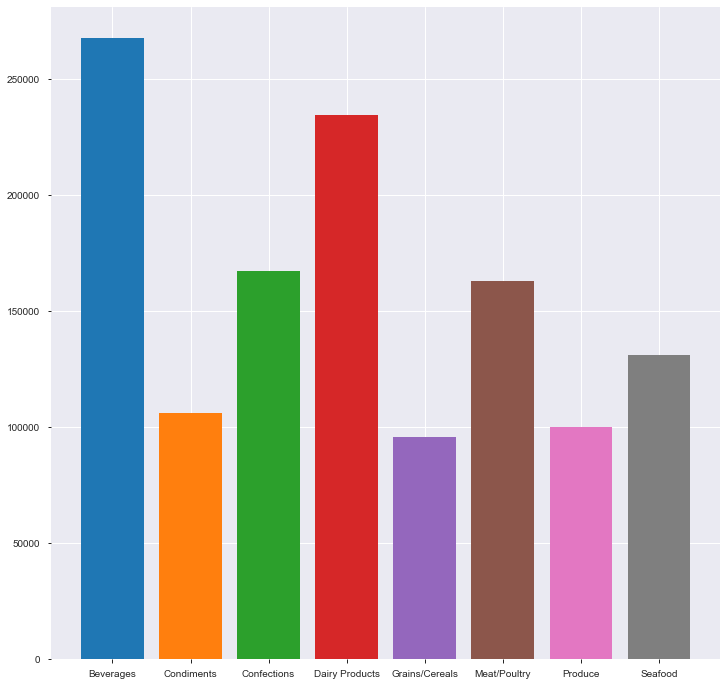

In [479]:
# plot order quantity totals by month
fig = plt.figure(figsize=(12,12))
for k,v in rev_per_cat.items():
    plt.bar(x=k, height=v)

In [ ]:
# What were the top 3 selling product categories in each region or country?
# What were the lowest 3 selling product categories in each region or country?